# RadarCOVID-Report

In [1]:
import os
import tempfile
import uuid

import dataframe_image as dfi
import matplotlib.ticker
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
matplotlib.rcParams['figure.figsize'] = (15, 6)

## COVID-19 Cases

In [3]:
confirmed_df = pd.read_csv("https://covid19tracking.narrativa.com/csv/confirmed.csv")
confirmed_df = confirmed_df[confirmed_df["Country_EN"] == "Spain"]
confirmed_df = confirmed_df[pd.isna(confirmed_df["Region"])]
confirmed_df.drop(columns=["Country_EN", "Country_ES", "Country_IT", "Region"], inplace=True)
confirmed_df = confirmed_df.transpose()
confirmed_df.reset_index(inplace=True)
confirmed_df.columns = ["sample_date_string", "cumulative_cases"]
confirmed_df["new_cases"] = confirmed_df.cumulative_cases.diff()
confirmed_df["rolling_mean_new_cases"] = confirmed_df.new_cases.rolling(7).mean()
confirmed_df.head()

,sample_date_string,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-01-23,0.0,NaN,NaN
1,2020-01-24,0.0,0.0,NaN
2,2020-01-25,0.0,0.0,NaN
3,2020-01-26,0.0,0.0,NaN
4,2020-01-27,0.0,0.0,NaN


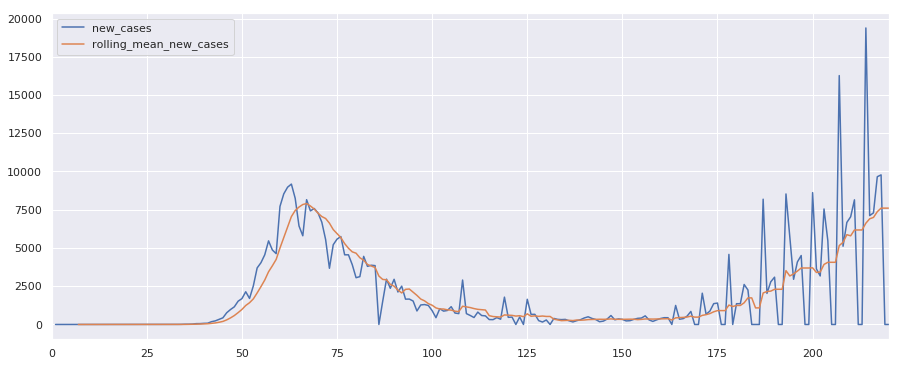

In [4]:
confirmed_df[["new_cases", "rolling_mean_new_cases"]].plot()

## RadarCOVID TEKs Extraction

In [5]:
from Modules.RadarCOVID import radar_covid

exposure_keys_df = radar_covid.download_last_radar_covid_exposure_keys(days=14)
exposure_keys_df[[
    "sample_date_string", "source_url", "region", "key_data"]].head()

,sample_date_string,source_url,region,key_data
0,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,421e9af1-43f8-183f-5211-538b976a54a7
1,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,107a2529-b759-57f6-51ad-b031417645cc
2,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,f3017c2c-95f0-47ef-5ac4-b831431d6257
3,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,734391b8-4f3a-b03f-2d54-648aed50a024
4,2020-08-30,https://radarcovid.covid19.gob.es/dp3t/v1/gaen...,ES,f79b036a-be91-f12e-cc80-5a620e1b60d7


In [6]:
exposure_keys_summary_df = \
    exposure_keys_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "tek_count"}, inplace=True)
exposure_keys_summary_df.head()

,tek_count
sample_date_string,
2020-08-30,15
2020-08-29,18
2020-08-28,34
2020-08-27,58
2020-08-26,69


## RadarCOVID TEKs Dump

In [7]:
import datetime

extraction_date = datetime.datetime.utcnow().strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
tek_list_df = exposure_keys_df[["sample_date_string", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    "sample_date").tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df.to_json(
    "Data/TEKs/Daily/RadarCOVID-TEKs-" + extraction_date + ".json",
    lines=True, orient="records")
tek_list_df.to_json(
    "Data/TEKs/Hourly/RadarCOVID-TEKs-" + extraction_date_with_hour + ".json",
    lines=True, orient="records")
tek_list_df.head()

,sample_date,tek_list,extraction_date
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-08-31
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-08-31
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-08-31
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-08-31
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-08-31


## RadarCOVID New TEKs

In [8]:
import glob

historic_tek_list_df = pd.DataFrame()

for path in glob.glob("Data/TEKs/Daily/RadarCOVID-TEKs-*.json"):
    extraction_tek_list_df = pd.read_json(path, lines=True)
    historic_tek_list_df = historic_tek_list_df.append(extraction_tek_list_df, sort=False)
    
historic_tek_list_df.head()

,sample_date,tek_list,extraction_date
0,2020-08-19,[645572b7-c0e2-97bc-9bcb-7107fb5eb1bc],2020-08-29
1,2020-08-20,"[5c4885a2-5c65-d6aa-8eed-7d607f106647, e6c3ca3...",2020-08-29
2,2020-08-21,"[53c82402-7f1c-e203-7abc-593dc3a8a9fe, fd16f69...",2020-08-29
3,2020-08-22,"[316fcc1d-9bdb-69ae-b997-70b5b4ca1d74, 33b23da...",2020-08-29
4,2020-08-23,"[3dda2de2-fc66-33b9-cf6b-c7b85f8683d5, c0a53a0...",2020-08-29


In [9]:
tek_list_df = historic_tek_list_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{375394c6-fcdc-5e9e-444c-3478ac5a7b64, a9dcdac..."
2020-08-30,"{375394c6-fcdc-5e9e-444c-3478ac5a7b64, a9dcdac..."
2020-08-31,"{375394c6-fcdc-5e9e-444c-3478ac5a7b64, a9dcdac..."


In [10]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "new_tek_count",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.head()

,sample_date_string,new_tek_count
0,2020-08-29,NaN
1,2020-08-30,29.0
2,2020-08-31,21.0


In [11]:
new_tek_devices_df = historic_tek_list_df.copy()
new_tek_devices_df["new_sample_extraction_date"] = \
    pd.to_datetime(new_tek_devices_df.sample_date) + datetime.timedelta(1)
new_tek_devices_df["extraction_date"] = pd.to_datetime(new_tek_devices_df.extraction_date)

new_tek_devices_df = new_tek_devices_df[
    new_tek_devices_df.new_sample_extraction_date == new_tek_devices_df.extraction_date]
new_tek_devices_df.head()

,sample_date,tek_list,extraction_date,new_sample_extraction_date
9,2020-08-28,"[757936ab-531c-4872-1d83-ce7a8d135211, 51d5fc9...",2020-08-29,2020-08-29
10,2020-08-29,"[1a509311-f96d-28f1-9d7d-414bf48272b9, 5bfad3a...",2020-08-30,2020-08-30
11,2020-08-30,"[421e9af1-43f8-183f-5211-538b976a54a7, 107a252...",2020-08-31,2020-08-31


In [12]:
new_tek_devices_df.set_index("extraction_date", inplace=True)
new_tek_devices_df = new_tek_devices_df.tek_list.apply(lambda x: len(set(x))).to_frame()
new_tek_devices_df.reset_index(inplace=True)
new_tek_devices_df.rename(columns={
    "extraction_date": "sample_date_string",
    "tek_list": "new_tek_devices"}, inplace=True)
new_tek_devices_df["sample_date_string"] = new_tek_devices_df.sample_date_string.dt.strftime("%Y-%m-%d")
new_tek_devices_df.head()

,sample_date_string,new_tek_devices
0,2020-08-29,27
1,2020-08-30,16
2,2020-08-31,15


## Data Merge

In [13]:
result_summary_df = exposure_keys_summary_df.merge(new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count
0,2020-08-30,15.0,29.0
1,2020-08-29,18.0,NaN
2,2020-08-28,34.0,NaN
3,2020-08-27,58.0,NaN
4,2020-08-26,69.0,NaN


In [14]:
result_summary_df = result_summary_df.merge(new_tek_devices_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices
0,2020-08-30,15.0,29.0,16.0
1,2020-08-29,18.0,NaN,27.0
2,2020-08-28,34.0,NaN,NaN
3,2020-08-27,58.0,NaN,NaN
4,2020-08-26,69.0,NaN,NaN


In [15]:
result_summary_df = result_summary_df.merge(confirmed_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases
0,2020-08-30,15.0,29.0,16.0,439286.0,0.0,7604.571429
1,2020-08-29,18.0,NaN,27.0,439286.0,0.0,7604.571429
2,2020-08-28,34.0,NaN,NaN,439286.0,9779.0,7604.571429
3,2020-08-27,58.0,NaN,NaN,429507.0,9658.0,7371.571429
4,2020-08-26,69.0,NaN,NaN,419849.0,7296.0,6997.428571


In [16]:
result_summary_df["tek_count_per_new_case"] = \
    result_summary_df.tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_case"] = \
    result_summary_df.new_tek_count / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_devices_per_new_case"] = \
    result_summary_df.new_tek_devices / result_summary_df.rolling_mean_new_cases
result_summary_df["new_tek_count_per_new_tek_device"] = \
    result_summary_df.new_tek_count / result_summary_df.new_tek_devices
result_summary_df.head()

,sample_date_string,tek_count,new_tek_count,new_tek_devices,cumulative_cases,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
0,2020-08-30,15.0,29.0,16.0,439286.0,0.0,7604.571429,0.001972,0.003813,0.002104,1.8125
1,2020-08-29,18.0,NaN,27.0,439286.0,0.0,7604.571429,0.002367,NaN,0.003550,NaN
2,2020-08-28,34.0,NaN,NaN,439286.0,9779.0,7604.571429,0.004471,NaN,NaN,NaN
3,2020-08-27,58.0,NaN,NaN,429507.0,9658.0,7371.571429,0.007868,NaN,NaN,NaN
4,2020-08-26,69.0,NaN,NaN,419849.0,7296.0,6997.428571,0.009861,NaN,NaN,NaN


## Results

In [17]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df = result_summary_df.sort_index(ascending=False)

In [18]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[[
    "tek_count",
    "new_tek_count",
    "new_cases",
    "rolling_mean_new_cases",
    "tek_count_per_new_case",
    "new_tek_count_per_new_case",
    "new_tek_devices",
    "new_tek_devices_per_new_case",
    "new_tek_count_per_new_tek_device"]]
result_summary_df

,tek_count,new_tek_count,new_cases,rolling_mean_new_cases,tek_count_per_new_case,new_tek_count_per_new_case,new_tek_devices,new_tek_devices_per_new_case,new_tek_count_per_new_tek_device
sample_date,,,,,,,,,
2020-08-31,NaN,21.0,NaN,NaN,NaN,NaN,15.0,NaN,1.4000
2020-08-30,15.0,29.0,0.0,7604.571429,0.001972,0.003813,16.0,0.002104,1.8125
2020-08-29,18.0,NaN,0.0,7604.571429,0.002367,NaN,27.0,0.003550,NaN
2020-08-28,34.0,NaN,9779.0,7604.571429,0.004471,NaN,NaN,NaN,NaN
2020-08-27,58.0,NaN,9658.0,7371.571429,0.007868,NaN,NaN,NaN,NaN
2020-08-26,69.0,NaN,7296.0,6997.428571,0.009861,NaN,NaN,NaN,NaN
2020-08-25,58.0,NaN,7117.0,6908.142857,0.008396,NaN,NaN,NaN,NaN
2020-08-24,48.0,NaN,19382.0,6622.000000,0.007249,NaN,NaN,NaN,NaN
2020-08-23,28.0,NaN,0.0,6177.285714,0.004533,NaN,NaN,NaN,NaN


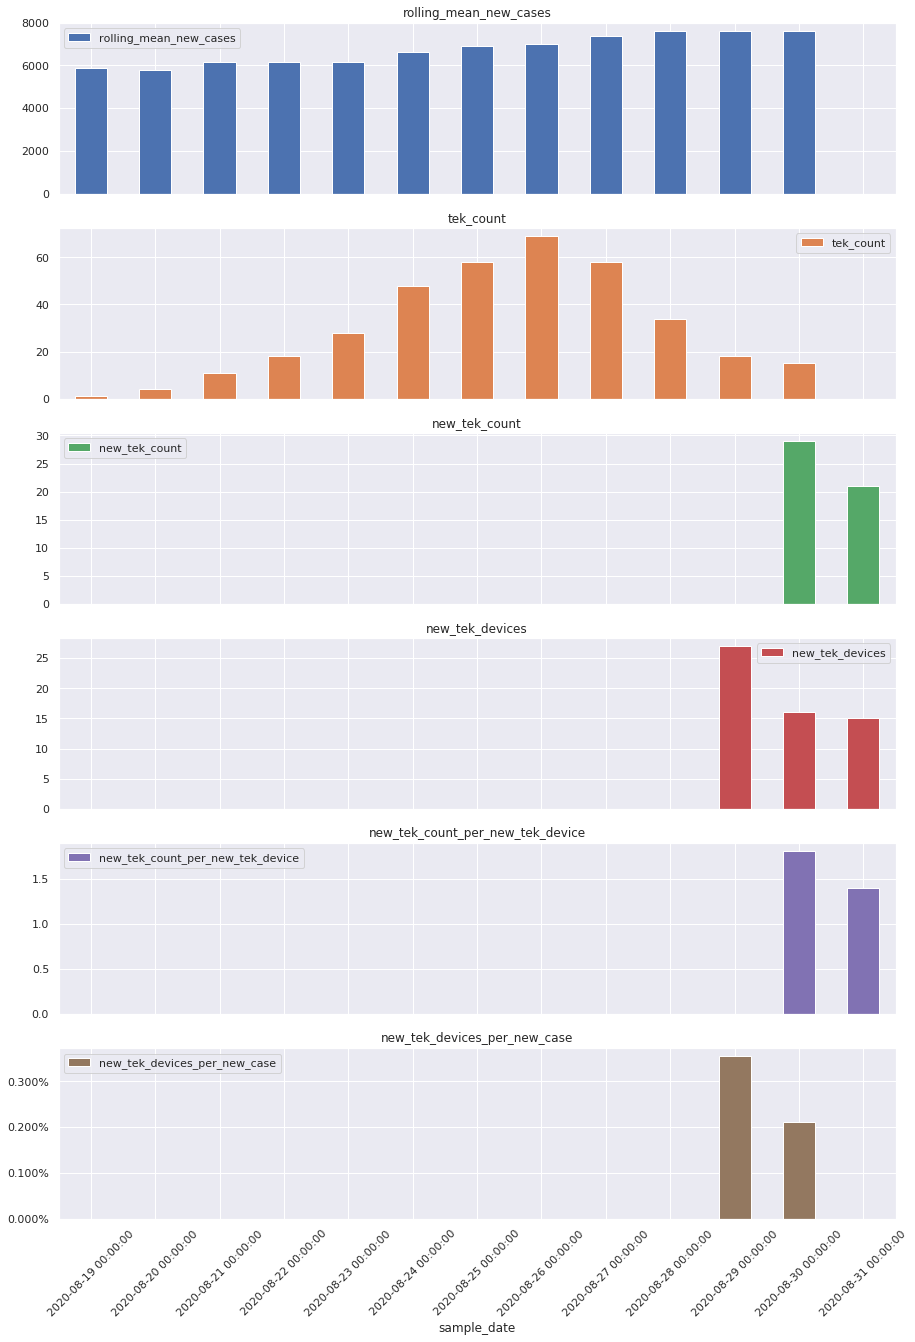

In [19]:
summary_ax_list = result_summary_df[[
    "rolling_mean_new_cases",
    "tek_count",
    "new_tek_count",
    "new_tek_devices",
    "new_tek_count_per_new_tek_device",
    "new_tek_devices_per_new_case"
]].sort_index(ascending=True).plot.bar(
    rot=45, subplots=True, figsize=(15, 22))
summary_ax_list[-1].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))

## Share to Twitter

In [20]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_SHARE_TO_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule":
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    def get_temporary_twitter_media_path() -> str:
        return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

    def upload_plot_to_twitter(ax):
        media_path = get_temporary_twitter_media_path()
        ax.get_figure().savefig(media_path)
        return api.media_upload(media_path)

    def upload_dataframe_to_twitter(df):
        media_path = get_temporary_twitter_media_path()
        dfi.export(df, media_path)
        return api.media_upload(media_path)

    summary_plot_media = upload_plot_to_twitter(ax=summary_ax_list[0])
    summary_table_media = upload_dataframe_to_twitter(df=result_summary_df)

    api.update_status(
        f"Report Update – {extraction_date}: "
        f"https://github.com/pvieito/RadarCOVID-Report/blob/master/Notebooks/"
        f"RadarCOVID-Report-{extraction_date}.ipynb",
        media_ids=[summary_plot_media.media_id, summary_table_media.media_id])